In [158]:
# Define task

from _collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
import os

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import normalize
import seaborn as sns
import warnings
from datasets import sf_inputs_discrete

# Parameter settings

In [159]:
spatial_sigmas = [0.0, 1.0, 2.0, 3.0]
sparsity_range = [[0.001, 0.2], [0.001, 0.1], [0.001, 0.04], [0.001, 0.023]]
spatial_sigmas.extend([
    0.25,
    0.5,
    1.25,
    1.5,
    1.75,
    2.25,
    2.5,
    2.75,
    3.25
    ])
sparsity_range.extend([
    [0.001, 0.19], # 0.25
    [0.001, 0.15], # 0.5
    [0.001, 0.09], # 1.25
    [0.001, 0.05], # 1.5
    [0.001, 0.045], # 1.75
    [0.001, 0.037], # 2.25
    [0.001, 0.03], # 2.5
    [0.001, 0.025], # 2.75
    [0.001, 0.021], # 3.25
    ])

# Helper functions

In [160]:
arena_length = 14
num_states = arena_length**2
num_steps= 3000
dataset = sf_inputs_discrete.Sim2DWalk

In [186]:
def collect_distances(use_r0=False, distance_metric='l2'):
    sparsities = []
    sigmas = []
    distances = []
    for idx, spatial_sigma in enumerate(spatial_sigmas):
        _range = sparsity_range[idx]
        sparsity_ps = np.linspace(_range[0], _range[1], num=20, endpoint=True)
        for sparsity_p in sparsity_ps:
            for _ in range(3):
                feature_maker_kwargs = {
                    'feature_dim': num_states,
                    'feature_type': 'correlated_distributed',
                    'feature_vals_p': [1-sparsity_p, sparsity_p],
                    'spatial_sigma': spatial_sigma,
                    'gaussian_truncate': 1.
                    }
                dataset_config = {
                    'num_steps': num_steps,
                    'feature_maker_kwargs': feature_maker_kwargs,
                    'num_states': num_states
                }
                dset = dataset(**dataset_config)
                dset_inputs = dset.dg_inputs
                features = dset.feature_maker.feature_map # (features, states)
                
                # Calculate r0 matrix
                if use_r0:
                    r0 = np.zeros((features.shape[0], features.shape[0])) #np.linalg.pinv(np.cov(features))
                    for t in range(dset_inputs.shape[1]-1):
                        r0 += np.outer(dset_inputs[:,t], dset_inputs[:,t])
                    r0 = np.linalg.pinv(r0/t)
                    #r0 = r0 / (r0.sum(axis=1)+1E-4)[:, np.newaxis]
                    #feature_norm = np.mean(np.linalg.norm(r0@features, axis=1))
                    feature_norm = np.mean(np.linalg.norm(r0, axis=1))
                else:
                    feature_norm = 1 #np.mean(np.linalg.norm(features, axis=1))
                
                # Randomly sample feature pairs to calculate distance
                for sample in range(50):
                    i = np.random.choice(features.shape[1])
                    j = np.random.choice(features.shape[1])
                    
                    # Features before or after embedding
                    if use_r0:
                        feat_i = r0@features[:,i]
                        feat_j = r0@features[:,j]
                    else:
                        feat_i = features[:,i]
                        feat_j = features[:,j]

                    # Get distance metric
                    if distance_metric =='l2':
                        dist = np.linalg.norm(feat_i - feat_j)
                    elif distance_metric =='l2-normalized':
                        dist = np.linalg.norm(feat_i - feat_j)
                        dist /= feature_norm
                    elif distance_metric == 'cos-similarity':
                        dist = np.dot(feat_i, feat_j)
                        dist /= (np.linalg.norm(feat_i)*np.linalg.norm(feat_j))
                    else:
                        raise ValueError('Distance metric not understood.')
                        
                    # Collect result
                    sigmas.append(spatial_sigma)
                    sparsities.append(dset.feature_maker.post_smooth_sparsity)
                    distances.append(dist)
    sparsities = np.around(sparsities, decimals=2)
    return sigmas, sparsities, distances

In [165]:
def get_df(sigmas, sparsities, distances):
    x = []
    y = []
    z = []
    for sparsity in np.unique(sparsities):
        for sigma in np.unique(sigmas):
            idxs = np.logical_and(sparsities==sparsity, sigmas==sigma)
            if idxs.size == 0: continue
            x.append(sparsity)
            y.append(sigma)
            z.append(np.mean(
                np.array(distances)[idxs]
                ))
    df = pd.DataFrame({
        'Sparsity': x,
        'Sigma': y,
        'Distance': z
    })
    return df

# Pre-embedding, L2

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


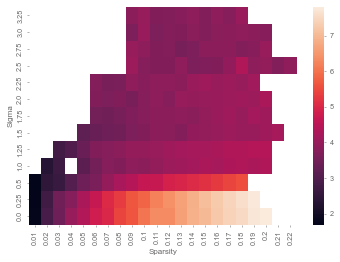

In [180]:
sigmas, sparsities, distances = collect_distances(use_r0=False, distance_metric='l2')
df = get_df(sigmas, sparsities, distances)
newdf = df.pivot("Sparsity", "Sigma", "Distance")
ax = sns.heatmap(newdf.T[::-1])

# Post-embedding, L2

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


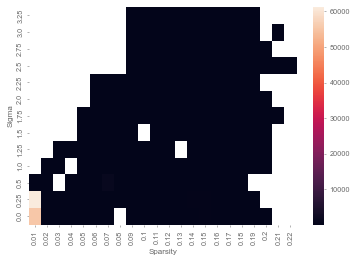

In [185]:
sigmas, sparsities, distances = collect_distances(use_r0=True, distance_metric='l2')
df = get_df(sigmas, sparsities, distances)
newdf = df.pivot("Sparsity", "Sigma", "Distance")
ax = sns.heatmap(newdf.T[::-1])

# Pre-embedding, Normalized L2

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


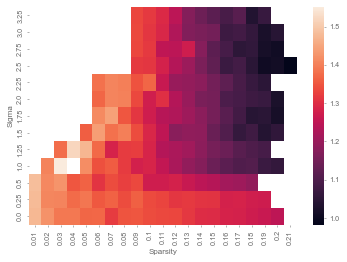

In [166]:
sigmas, sparsities, distances = collect_distances(use_r0=False, distance_metric='l2-normalized')
df = get_df(sigmas, sparsities, distances)
newdf = df.pivot("Sparsity", "Sigma", "Distance")
ax = sns.heatmap(newdf.T[::-1])

# Post-embedding, Normalized L2

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


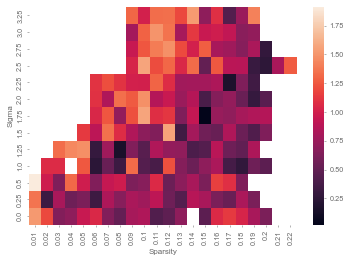

In [173]:
sigmas, sparsities, distances = collect_distances(use_r0=True, distance_metric='l2-normalized')
df = get_df(sigmas, sparsities, distances)
newdf = df.pivot("Sparsity", "Sigma", "Distance")
ax = sns.heatmap(newdf.T[::-1])

# Pre-embedding, Normalized L2 by R0

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


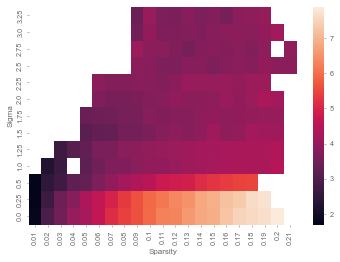

In [187]:
sigmas, sparsities, distances = collect_distances(use_r0=False, distance_metric='l2-normalized')
df = get_df(sigmas, sparsities, distances)
newdf = df.pivot("Sparsity", "Sigma", "Distance")
ax = sns.heatmap(newdf.T[::-1])

# Post-embedding, Normalized L2 by R0

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


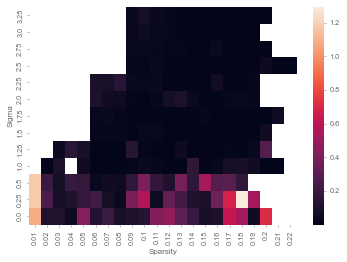

In [188]:
sigmas, sparsities, distances = collect_distances(use_r0=True, distance_metric='l2-normalized')
df = get_df(sigmas, sparsities, distances)
newdf = df.pivot("Sparsity", "Sigma", "Distance")
ax = sns.heatmap(newdf.T[::-1])

In [213]:
def make_gradients(
    x_key, y_key, z_key, df,
    cmap="Reds",
    title=None, xlabel=None, ylabel=None,
    figname=None, figsize=[6.4, 4.8],
    interpolate=False, smooth=False, contours=None,
    leave_edge_nans=True, vmin=None, vmax=None,
    cbar_ticks=None, cbar_tick_labels=None
    ):
    
    # Load in data
    xs = df[x_key].to_numpy()
    ys = df[y_key].to_numpy()
    zs = np.abs(df[z_key].to_numpy())
    
    # Collect data into a meshgrid
    x_list = np.sort(np.unique(xs))
    y_list = np.sort(np.unique(ys))
    dxs = np.around(x_list[1:] - x_list[:-1], decimals=2)
    dys = np.around(y_list[1:] - y_list[:-1], decimals=2)
    if np.unique(dxs).size > 1 or np.unique(dys).size > 1:
        if smooth:
            print("Warning: Smoothing with inconsistent dx/dy")
    x_list = np.concatenate((x_list, [x_list[-1]+dxs[-1]]))
    y_list = np.concatenate((y_list, [y_list[-1]+dys[-1]]))
    x, y = np.meshgrid(x_list, y_list)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            idx = np.logical_and(
                xs==x[i,j], ys==y[i,j]
                )
            z[i,j] = np.nanmean(zs[idx])
    cmap = plt.get_cmap(cmap)
    cmap.set_bad('yellow')

    # Plot raw grid values
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.pcolormesh(
        x, y, z, cmap=cmap
        )
    fig.colorbar(im, ax=ax)
    plt.show()
    
    # Remove padding used for pcolormesh plot
    x = x[:-1,:-1]
    y = y[:-1,:-1]
    z = z[:-1,:-1]
    
    # Mark NaNs
    nan_mask = np.isnan(z)
    edge_nan_mask = get_edge_nans(z)
    
    # Interpolate to fill in NaN cells
    if interpolate:
        if np.sum(nan_mask) > 0:
            nonnan_mask = np.logical_not(nan_mask)
            nan_indices = np.argwhere(nan_mask)
            data_X = np.vstack(
                [x[nonnan_mask].flatten(),
                 y[nonnan_mask].flatten()]).T
            data_y = z[nonnan_mask].flatten()
            reg = LinearRegression().fit(data_X, data_y)
            interp_vals = reg.predict(
                np.vstack(
                [x[nan_mask].flatten(),
                 y[nan_mask].flatten()]).T
                )
            z[nan_mask] = interp_vals

    
    # Smooth over cells to denoise
    if smooth:
        from astropy.convolution import Gaussian2DKernel
        from astropy.convolution import convolve
        kernel = Gaussian2DKernel(
            x_stddev=1., y_stddev=1.,
            #x_size=3, y_size=3
            )
        z = convolve(z, kernel, preserve_nan=True)
        
    # Generate contour plots
    fig, ax = plt.subplots(figsize=figsize)
    z = np.clip(z, 0, np.inf)
    if vmin is not None and vmax is not None:
        levels = MaxNLocator(nbins=20).tick_values(np.nanmin(vmin), np.nanmax(vmax))
    else:
        levels = MaxNLocator(nbins=20).tick_values(np.nanmin(z), np.nanmax(z))
    cf = ax.contourf(x, y, z,
                     levels=levels, cmap=cmap,
                     vmin=vmin, vmax=vmax, 
                     )
    if leave_edge_nans: # White out parts that were extrapolated
        nans = np.argwhere(edge_nan_mask)
        nan1 = nans[0]; nan2 = nans[-1]
        nan1x = x[nan1[0],nan1[1]]
        nan1y = y[nan1[0],nan1[1]]
        nan2x = x[nan2[0],nan2[1]]
        nan2y = y[nan2[0],nan2[1]]
        max_y = y.max()
        plt.fill(
            [nan1x, nan2x, nan1x],
            [nan1y, nan2y, max_y],
            color='white'
            )
    if contours is not None:
        cntrs = plt.contour(
            x, y, z, contours,
            colors='white', linewidths=0.5
            )
        plt.clabel(cntrs, inline=True)
    cbar = fig.colorbar(cf, ax=ax, ticks=cbar_ticks)
    if cbar_ticks is not None:
        cbar.ax.set_yticklabels(cbar_tick_labels)
    ax.set_title('contourf with levels')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xs.min(), 0.20)
    plt.tight_layout()
    plt.savefig(f'{figname}.png', dpi=300, transparent=True)
    plt.show()
    
    return x, y, z

In [190]:
def get_nan_mask(im, leave_edge_nans=False):
    """ im is processed row-by-row (e.g., sigma by sparsity) """
    
    if not leave_edge_nans:
        return np.isnan(im)
    else:
        mask = np.isnan(im)
        nrows, ncols = im.shape
        for i in range(nrows):
            j = 0
            while np.isnan(im[i,j]) and (j < ncols):
                mask[i,j] = False
                j += 1
        return mask

In [191]:
def get_edge_nans(im):
    """ im is processed row-by-row (e.g., sigma by sparsity) """
    
    mask = np.zeros(im.shape).astype(bool)
    nrows, ncols = im.shape
    for i in range(nrows):
        j = 0
        while np.isnan(im[i,j]) and (j < ncols):
            mask[i,j] = True
            j += 1
    return mask

In [192]:
from sklearn.linear_model import LinearRegression
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

# Pre-embedding, Cosine similarity

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


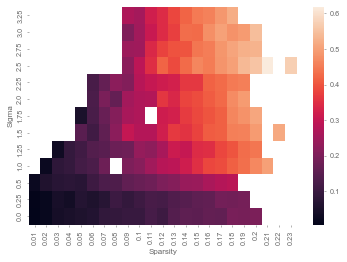

In [193]:
sigmas, sparsities, distances = collect_distances(use_r0=False, distance_metric='cos-similarity')
df = get_df(sigmas, sparsities, distances)
newdf = df.pivot("Sparsity", "Sigma", "Distance")
ax = sns.heatmap(newdf.T[::-1])

In [202]:
xx = df.copy()

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_7424/4076885550.py:33: RuntimeWarning: Mean of empty slice
  z[i,j] = np.nanmean(zs[idx])
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_7424/4076885550.py:35: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Purples").copy()
  cmap.set_bad('yellow')
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_7424/4076885550.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(


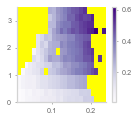

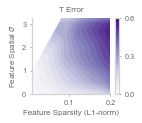

In [215]:
_, _, _ = make_gradients(
    'Sparsity', 'Sigma', 'Distance', xx,
    cmap='Purples',
    title='T Error',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname='../figures/icml_pre_embedding',
    interpolate=True, smooth=True,
    vmin=0., vmax=0.6,
    cbar_ticks=[0., 0.3, 0.6],
    cbar_tick_labels=['0.0', '0.3', '0.6'],
    figsize=[2., 1.75]
    )

# Post-embedding, Cosine similarity

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_7424/2642477943.py:59: RuntimeWarning: invalid value encountered in double_scalars
  dist /= (np.linalg.norm(feat_i)*np.linalg.norm(feat_j))
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_7424/2642477943.py:59: RuntimeWarning: invalid value encountered in double_scalars
  dist /= (np.linalg.norm(feat_i)*np.linalg.norm(feat_j))
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_7424/2642477943.py:59: RuntimeWarning: invalid value encountered in double_scalars
  dist /= (np.linalg.norm(feat_i)*np.linalg.norm(feat_j))
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_7424/2642477943.py:59: RuntimeWarning: invalid value encountered in double_scalars
  dist /= (np.linalg.norm(feat_i)*np.linalg.norm(feat_j))
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ch

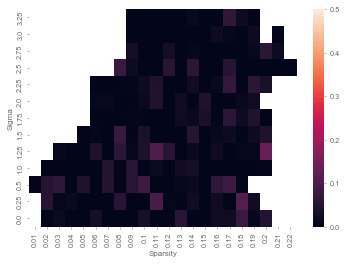

In [203]:
sigmas, sparsities, distances = collect_distances(use_r0=True, distance_metric='cos-similarity')
df = get_df(sigmas, sparsities, distances)
newdf = df.pivot("Sparsity", "Sigma", "Distance")
ax = sns.heatmap(newdf.T[::-1], vmin=0, vmax=0.5)

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_7424/4076885550.py:33: RuntimeWarning: Mean of empty slice
  z[i,j] = np.nanmean(zs[idx])
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_7424/4076885550.py:35: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Purples").copy()
  cmap.set_bad('yellow')
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_7424/4076885550.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(


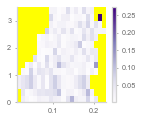

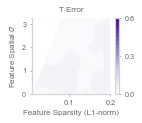

In [214]:
_, _, _ = make_gradients(
    'Sparsity', 'Sigma', 'Distance', df,
    cmap='Purples',
    title='T Error',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname='../figures/icml_post_embedding',
    interpolate=True, smooth=True,
    vmin=0, vmax=0.6,
    cbar_ticks=[0., 0.3, 0.6],
    cbar_tick_labels=['0.0', '0.3', '0.6'],
    figsize=[2., 1.75]
    )